In [6]:
# conda activate SpaceHack_MM
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.linear_model import RANSACRegressor, LinearRegression 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import sparse
import numpy as np
import pandas as pd
import libpysal as lps
from esda import Moran
import seaborn as sns

In [7]:
def load_h5ad_data(file_path):
    adata = sc.read_h5ad(file_path)
    return adata

def ensure_dense(matrix):
    # Check if the matrix is sparse and needs conversion
    return matrix.toarray() if hasattr(matrix, 'toarray') else matrix

def detect_outliers(adata1, adata2, scale_data=True, gene_name='', inlier_threshold=0.7, display_plot=False):
    """
    Detect outliers in gene expression data using RANSAC regression.

    Parameters:
    - adata1: AnnData object for dataset 1.
    - adata2: AnnData object for dataset 2.
    - scale_data: Boolean indicating whether to scale the data.
    - gene_name: Specific gene to visualize (if empty, visualizes the first inlier).
    - inlier_threshold: Proportion of inliers required to classify a gene as an inlier.
    - display_plot: Boolean indicating whether to display the plot.

    Returns:
    - Prints lists of inlier and outlier genes.
    """
    
    # Prepare inputs
    X = ensure_dense(adata1.X)  # Convert adata1.X to dense if necessary
    Y = ensure_dense(adata2.X)  # Convert adata2.X to dense if necessary

    genes1 = adata1.var_names
    genes2 = adata2.var_names

    # Create DataFrames
    df1 = pd.DataFrame(X, columns=genes1)
    df2 = pd.DataFrame(Y, columns=genes2)
    
    # Remove genes containing 'UnassignedCodeword' from both datasets
    mask1 = ~df1.columns.str.contains('UnassignedCodeword|NegControlProbe|NegControlCodeword', case=False)
    mask2 = ~df2.columns.str.contains('UnassignedCodeword|NegControlProbe|NegControlCodeword', case=False)

    df1 = df1.loc[:, mask1]
    df2 = df2.loc[:, mask2]

    # Find common genes after filtering
    common_genes = list(set(df1.columns).intersection(set(df2.columns)))

    # Initialize lists to store results
    inlier_genes = []
    outlier_genes = []

    # Analyze each common gene independently
    for gene in common_genes:
        # Extract expression levels for the current gene
        X_gene = df1[gene].dropna().to_numpy()  # Drop NaN values if any
        Y_gene = df2[gene].dropna().to_numpy()  # Drop NaN values if any

        # If either dataset has no data for this gene, skip it
        if len(X_gene) == 0 or len(Y_gene) == 0:
            continue

        # Use only the minimum length of the two arrays for fitting
        min_length = min(len(X_gene), len(Y_gene))

        # Optionally normalize the data based on the scale_data flag
        if scale_data:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_gene[:min_length].reshape(-1, 1))
            Y_scaled = scaler.fit_transform(Y_gene[:min_length].reshape(-1, 1))
        else:
            X_scaled = X_gene[:min_length].reshape(-1, 1)
            Y_scaled = Y_gene[:min_length].reshape(-1, 1)

        # Fit RANSAC regressor for the current gene using only available data
        ransac = RANSACRegressor(random_state=42)
        ransac.fit(X_scaled, Y_scaled)

        # Extract inliers and outliers for this gene
        inlier_mask = ransac.inlier_mask_

        # Calculate proportion of inliers
        proportion_inliers = np.sum(inlier_mask) / min_length
        
        # Check if proportion of inliers meets threshold
        if proportion_inliers >= inlier_threshold:
            inlier_genes.append(gene)
        else:
            outlier_genes.append(gene)

    # Select a specific gene to visualize (if provided)
    selected_gene = gene_name if gene_name else (inlier_genes[0] if inlier_genes else None)

    if selected_gene and display_plot:
        X_selected = df1[selected_gene].dropna().to_numpy().reshape(-1, 1)
        Y_selected = df2[selected_gene].dropna().to_numpy().reshape(-1, 1)

        # Align lengths for visualization
        min_length = min(len(X_selected), len(Y_selected))
        
        # Optionally normalize the data based on the scale_data flag
        if scale_data:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_selected[:min_length].reshape(-1, 1))
            Y_scaled = scaler.fit_transform(Y_selected[:min_length].reshape(-1, 1))
        else:
            X_scaled = X_selected[:min_length].reshape(-1, 1)
            Y_scaled = Y_selected[:min_length].reshape(-1, 1)

        ransac.fit(X_scaled, Y_scaled)
        inlier_mask_visual = ransac.inlier_mask_

        plt.figure(figsize=(8, 5))
        plt.scatter(X_scaled[inlier_mask_visual], Y_scaled[inlier_mask_visual], color='blue', label='Inliers')
        plt.scatter(X_scaled[~inlier_mask_visual], Y_scaled[~inlier_mask_visual], color='red', label='Outliers')

        # Plotting the RANSAC fit line based on scaled data
        plt.plot(X_scaled, ransac.predict(X_scaled), color='green', label='RANSAC fit')

        plt.xlabel(f'Gene Expression (Dataset 1) - {selected_gene}')
        plt.ylabel(f'Gene Expression (Dataset 2) - {selected_gene}')
        plt.title(f'RANSAC Outlier Detection for {selected_gene}')
        plt.legend()
        plt.show()
    else:
        print("No inliers found to visualize or plotting is disabled.")

    # Print outlier and inlier genes
    print("Inlier Genes:", inlier_genes)
    print("Inlier nGenes:", len(inlier_genes))
    print("Outlier Genes:", outlier_genes)
    print("Outlier nGenes:", len(outlier_genes))

    return inlier_genes, outlier_genes


def calculate_moran_scores(gene_list, adata, distance_threshold, x_coord_col='x_centroid', y_coord_col='y_centroid'):
    """
    Calculate Moran's I scores for a list of genes in a given AnnData object.

    Parameters:
    - gene_list: List of genes to analyze.
    - adata: AnnData object containing the expression data and spatial coordinates.
    - distance_threshold: Distance threshold for creating spatial weights.
    - x_coord_col: Name of the column in adata.obs for x coordinates.
    - y_coord_col: Name of the column in adata.obs for y coordinates.

    Returns:
    - DataFrame containing Moran's I scores and p-values for each gene.
    """
    
    # Step 1: Filter the AnnData object for the genes of interest
    filtered_genes = [gene for gene in gene_list if gene in adata.var_names]

    # Extract the expression data for the filtered genes
    gene_expression = adata[:, filtered_genes].X  # This will give a sparse matrix

    # Convert sparse matrix to dense if necessary
    if hasattr(gene_expression, 'toarray'):
        gene_expression = gene_expression.toarray()  # Convert to dense if it's sparse

    # Step 2: Extract coordinates from adata.obs using specified columns
    coords = adata.obs[[x_coord_col, y_coord_col]].values

    # Step 3: Create a spatial weights matrix (distance-based)
    w = lps.weights.DistanceBand(coords, threshold=distance_threshold)

    # Step 4: Calculate Moran's I for each gene of interest
    results = []
    
    for i, gene in enumerate(filtered_genes):
        moran = Moran(gene_expression[:, i], w)
        results.append({
            'Gene': gene,
            'Moran_I': moran.I,
            'p_value': moran.p_sim
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df






In [8]:
## Load data 

## Touchstone project data
file_path_1 = '/mnt/scratch1/spatial_compare/touchstone_data/TOUCHSTONE_UOA_CR_FFPE_BR_1_SYD_C_R1.h5ad'
file_path_2 = '/mnt/scratch1/spatial_compare/touchstone_data/TOUCHSTONE_UOA_XR_FFPE_BR_1_SYD_C_R1.h5ad'
adata1 = load_h5ad_data(file_path_1)
adata2 = load_h5ad_data(file_path_2)



# ## Brian's downsized data
# file_path_1 = '/mnt/scratch1/maycon/SpaceHack/spatial_compare/data/CJ_BG_mini1.h5ad'
# file_path_2 = '/mnt/scratch1/maycon/SpaceHack/spatial_compare/data/CJ_BG_mini2.h5ad'
# adata1 = load_h5ad_data(file_path_1)
# adata2 = load_h5ad_data(file_path_2)


In [ ]:
coords = adata1.obs[['CenterX_global_px', 'CenterY_global_px']].values
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5)
plt.title('Cell Spatial Distribution')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [13]:
# Filtering adata
coords = adata1.obs[['CenterX_global_px', 'CenterY_global_px']].values

# Step 2: Create boolean masks for filtering
mask_x = (adata1.obs['CenterX_global_px'] > 0) & (adata1.obs['CenterX_global_px'] < 10000)
mask_y = (adata1.obs['CenterY_global_px'] > 0) & (adata1.obs['CenterY_global_px'] < 10000)

# Step 3: Combine masks to create a final mask
final_mask = mask_x & mask_y

# Step 4: Filter the AnnData object
adata1 = adata1[final_mask].copy()

In [11]:
adata2.obs

,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area
cell_id,,,,,,,,,,
aaaaeamn-1,1445.145386,10993.522461,57,0,0,0,0,57,248.314228,33.370470
aaaaeoei-1,1465.101074,10985.144531,82,0,0,0,0,82,522.096581,75.862503
aaaageii-1,1466.928589,10967.678711,68,0,0,0,0,68,308.597824,29.125782
aaaagggi-1,1491.866821,10962.814453,113,0,0,0,0,113,523.586738,31.293282
aaaajbbl-1,1486.631348,10983.908203,34,0,0,0,0,34,445.285797,28.358126
...,...,...,...,...,...,...,...,...,...,...
oihfogkg-1,9195.631836,12691.512695,58,0,0,0,0,58,312.390949,31.338439
oihfpgnn-1,9196.455078,12719.427734,20,0,0,0,0,20,89.635160,17.340001
oihfphla-1,9195.349609,12736.282227,186,0,0,0,0,186,168.703756,78.662190


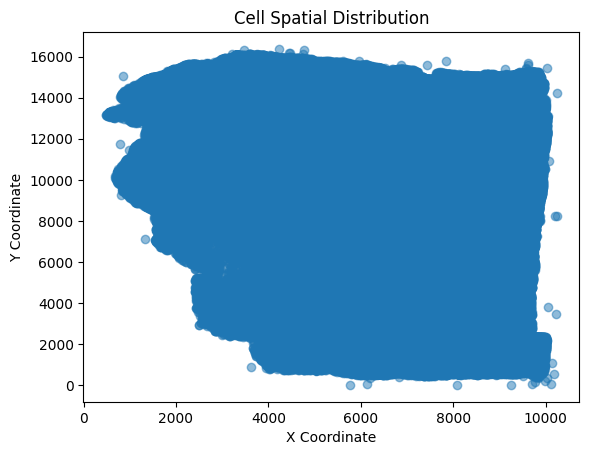

In [12]:
coords = adata2.obs[['x_centroid', 'y_centroid']].values
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5)
plt.title('Cell Spatial Distribution')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [23]:
# Filtering adata
coords = adata2.obs[['x_centroid', 'y_centroid']].values

# Step 2: Create boolean masks for filtering
mask_x = (adata2.obs['x_centroid'] > 4000) & (adata2.obs['x_centroid'] < 6000)
mask_y = (adata2.obs['y_centroid'] > 0) & (adata2.obs['y_centroid'] < 2000)

# Step 3: Combine masks to create a final mask
final_mask = mask_x & mask_y

# Step 4: Filter the AnnData object
adata2 = adata2[final_mask].copy()

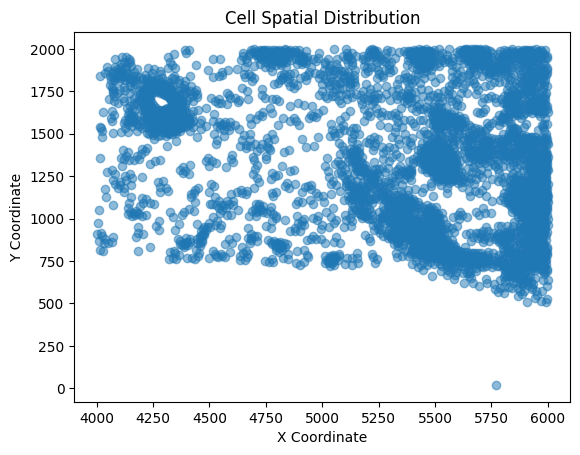

In [24]:
coords = adata2.obs[['x_centroid', 'y_centroid']].values
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5)
plt.title('Cell Spatial Distribution')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [25]:
print(adata1.shape)
print(adata2.shape)

(5100, 1207)
(4506, 541)


##  Using Outliers

In [34]:
## Get outlier genes 
# The outlier genes actually are the "good" genes. They should have statistical significance for autocorrelation (spatial corraltion)

inlier_genes, outlier_genes = detect_outliers(adata1, adata2, scale_data=True, gene_name='', inlier_threshold=0.90, display_plot=False) # work around the inlier_threshold to get a decent number of outlier genes

/mnt/scratch1/miniconda3/envs/SpaceHack_MM/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


No inliers found to visualize or plotting is disabled.
Inlier Genes: ['NCAM1', 'AQP3', 'AR', 'KDR', 'KRT23', 'CD86', 'GNLY', 'SELL', 'MS4A1', 'MMP12', 'RAMP2', 'CTLA4', 'CD80', 'DUSP5', 'CD3G', 'PDCD1LG2', 'TCL1A', 'ITGAX', 'KIT', 'ESR1', 'PDCD1', 'TIGIT', 'S100A8', 'CPA3', 'CX3CR1', 'MMP1', 'CCR7', 'ITGAM', 'MZB1', 'PPARG', 'CTSG', 'CXCL5', 'CLEC14A', 'CD69', 'CCL8', 'CD27', 'CD83', 'SNAI1', 'LTB', 'FOXP3', 'DUSP2', 'IL3RA', 'PGR', 'HAVCR2', 'PIGR', 'CD79A', 'KLRF1', 'LAG3', 'NDUFA4L2', 'GZMA', 'ADIPOQ', 'NKG7', 'CD274', 'MKI67', 'TOP2A', 'ANGPT2', 'KLRB1', 'CENPF', 'CD8A', 'CD19', 'GZMK', 'TCF7', 'APOC1', 'PRF1', 'TNFRSF17', 'IL2RA']
Inlier nGenes: 66
Outlier Genes: ['TACSTD2', 'CCND1', 'DST', 'IL2RG', 'PDGFRA', 'FCER1G', 'FASN', 'CEACAM6', 'CD4', 'PTPRC', 'ERBB2', 'KRT5', 'MYH11', 'LUM', 'S100A4', 'GPR183', 'EGFR', 'C1QA', 'CD68', 'EPCAM', 'MMP2', 'CXCR4', 'CXCL16', 'PTGDS', 'PDGFRB', 'IGF1', 'KRT8', 'LYZ', 'DPT', 'ACTG2', 'CDH1', 'GATA3', 'SQLE', 'CD163', 'CD3E', 'CCL5', 'KRT14', '

In [58]:
adata1.obs

,fov,fov_x,Area,AspectRatio,Width,Height,Mean.PanCK,Max.PanCK,Mean.CD68,Max.CD68,...,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,cell,Slide,FOV,X_mm,Y_mm,fov_y
nan,0,1,3626,1.53,81,53,163,1362,42,225,...,3624,26,3624.000000,108645.07077,c_1_1_1,NaN,NaN,NaN,NaN,NaN
0.0,1,1,6836,1.02,96,94,190,919,154,3228,...,2196,58,2196.000000,108613.07077,c_1_1_2,1.0,1.0,0.000000,13.071059,1.0
1.0,2,1,4425,0.80,66,83,259,785,136,2602,...,2124,73,2124.000000,108598.07077,c_1_1_3,1.0,2.0,0.511916,13.071059,2.0
2.0,3,1,7128,1.08,107,99,201,1752,334,4707,...,2973,91,2973.000000,108580.07077,c_1_1_4,1.0,3.0,1.023831,13.071059,3.0
3.0,4,1,4130,0.97,71,73,364,2996,86,1370,...,1719,132,1719.000000,108539.07077,c_1_1_5,1.0,4.0,1.535747,13.071059,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nan,336752,400,3280,1.65,79,48,53,1426,97,5947,...,1169,4231,83376.998988,-4231.00000,c_1_400_1017,NaN,NaN,NaN,NaN,NaN
nan,336753,400,3164,2.26,95,42,93,990,43,364,...,1373,4234,83580.998988,-4234.00000,c_1_400_1018,NaN,NaN,NaN,NaN,NaN
nan,336754,400,2436,2.24,85,38,146,1284,35,786,...,3786,4236,85993.998988,-4236.00000,c_1_400_1019,NaN,NaN,NaN,NaN,NaN
nan,336755,400,1339,2.25,63,28,1321,2961,77,361,...,3639,4241,85846.998988,-4241.00000,c_1_400_1020,NaN,NaN,NaN,NaN,NaN


In [35]:
## Run Moran's score (autocorrelation test)
# 100 is the distance within the same unit we want the autocorrelation to be done. to find the best fit/value for this cutoff you can plot the the coordinates an look at their length

# moran_results_1_fOut = calculate_moran_scores(outlier_genes, adata1, 100, x_coord_col='x_centroid', y_coord_col='y_centroid')
moran_results_1_fOut = calculate_moran_scores(outlier_genes, adata1, 100, x_coord_col='CenterX_global_px', y_coord_col='CenterX_global_px')
print(moran_results_1_fOut)

# moran_results_2_fOut = calculate_moran_scores(outlier_genes, adata2, 100, x_coord_col='x_centroid', y_coord_col='y_centroid')
moran_results_2_fOut = calculate_moran_scores(outlier_genes, adata2, 100, x_coord_col='x_centroid', y_coord_col='y_centroid')
print(moran_results_2_fOut)

        Gene   Moran_I  p_value
0    TACSTD2  0.037557    0.001
1      CCND1  0.026340    0.001
2        DST  0.004361    0.040
3      IL2RG -0.000519    0.433
4     PDGFRA  0.002912    0.095
5     FCER1G  0.004530    0.032
6       FASN  0.049187    0.001
7    CEACAM6  0.040486    0.001
8        CD4  0.002465    0.148
9      PTPRC  0.000380    0.403
10     ERBB2  0.048934    0.001
11      KRT5  0.056268    0.001
12     MYH11  0.003631    0.057
13       LUM  0.035582    0.001
14    S100A4  0.008042    0.003
15    GPR183  0.000249    0.406
16      EGFR  0.002951    0.096
17      C1QA  0.013679    0.001
18      CD68  0.008866    0.001
19     EPCAM  0.030858    0.001
20      MMP2  0.022994    0.001
21     CXCR4  0.002756    0.118
22    CXCL16  0.007102    0.005
23     PTGDS -0.001028    0.360
24    PDGFRB  0.012646    0.001
25      IGF1 -0.000045    0.455
26      KRT8  0.044091    0.001
27       LYZ  0.005770    0.017
28       DPT  0.000599    0.377
29     ACTG2  0.011044    0.001
30      

/mnt/scratch1/miniconda3/envs/SpaceHack_MM/lib/python3.11/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 6.
  w = W(neighbors, weights, ids, **kwargs)
/mnt/scratch1/miniconda3/envs/SpaceHack_MM/lib/python3.11/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 6.
  W.__init__(


('WARNING: ', 6, ' is an island (no neighbors)')
        Gene   Moran_I  p_value
0    TACSTD2  0.206515    0.001
1      CCND1  0.153887    0.001
2        DST  0.175399    0.001
3      IL2RG  0.071752    0.001
4     PDGFRA  0.045945    0.001
5     FCER1G  0.059119    0.001
6       FASN  0.127099    0.001
7    CEACAM6  0.261354    0.001
8        CD4  0.069058    0.001
9      PTPRC  0.135836    0.001
10     ERBB2  0.310598    0.001
11      KRT5  0.222565    0.001
12     MYH11  0.131886    0.001
13       LUM  0.165535    0.001
14    S100A4  0.051077    0.001
15    GPR183  0.108595    0.001
16      EGFR  0.030985    0.001
17      C1QA  0.026200    0.001
18      CD68  0.055377    0.001
19     EPCAM  0.285903    0.001
20      MMP2  0.151345    0.001
21     CXCR4  0.128920    0.001
22    CXCL16  0.049883    0.001
23     PTGDS  0.062029    0.001
24    PDGFRB  0.075063    0.001
25      IGF1  0.116300    0.001
26      KRT8  0.267421    0.001
27       LYZ  0.185562    0.001
28       DPT  0.124550 

In [36]:
## Check the statistics for moran's test
print((moran_results_1_fOut['p_value'] <= 0.05).sum())
print((moran_results_1_fOut['p_value'] > 0.05).sum())

print((moran_results_2_fOut['p_value'] <= 0.05).sum())
print((moran_results_2_fOut['p_value'] > 0.05).sum())


35
19
54
0


In [37]:
# Filter results by statistical sig
moran_results_1_fOut = pd.DataFrame(moran_results_1_fOut)
filtered_res_1 = moran_results_1_fOut[moran_results_1_fOut['p_value'] <= 0.05]

moran_results_2_fOut = pd.DataFrame(moran_results_2_fOut)
filtered_res_2 = moran_results_2_fOut[moran_results_2_fOut['p_value'] <= 0.05]

Correlation Coefficient (R): 0.7334691473018057
R-squared: 0.537976990043638


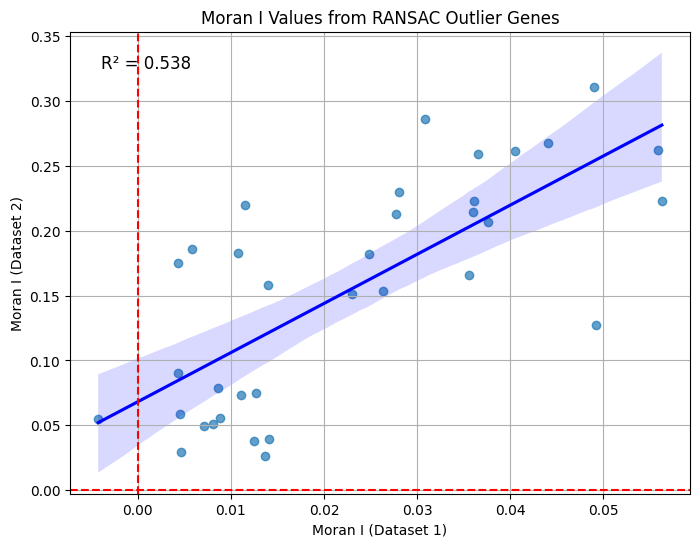

In [38]:
## Plot scatterplot of Moran's score on Outlier genes for both datasets
# Merge the two DataFrames on Gene
merged_df = pd.merge(filtered_res_1[['Gene', 'Moran_I']], filtered_res_2[['Gene', 'Moran_I']], on='Gene', suffixes=('_Dataset1', '_Dataset2'))

# Calculate Pearson correlation coefficient
correlation_coefficient = np.corrcoef(merged_df['Moran_I_Dataset1'], merged_df['Moran_I_Dataset2'])[0, 1]

# Calculate R-squared value
r_squared = correlation_coefficient ** 2
print(f"Correlation Coefficient (R): {correlation_coefficient}")
print(f"R-squared: {r_squared}")

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a scatter plot with a regression line
sns.regplot(data=merged_df, x='Moran_I_Dataset1', y='Moran_I_Dataset2', scatter_kws={'alpha':0.7}, line_kws={'color':'blue'})

# Add titles and labels
plt.title('Moran I Values from RANSAC Outlier Genes')
plt.xlabel('Moran I (Dataset 1)')
plt.ylabel('Moran I (Dataset 2)')

# Add horizontal and vertical lines at y=0 and x=0
plt.axhline(0, color='red', linestyle='--')
plt.axvline(0, color='red', linestyle='--')

# Add R-squared value to the plot
plt.text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

# Show grid
plt.grid()

# Show the plot
plt.show()

##  Using Inliers 


In [39]:
## Get outlier genes 
# The inliers genes actually are the "bad" genes. They should NOT have statistical significance for autocorrelation (spatial corraltion)

inlier_genes, outlier_genes = detect_outliers(adata1, adata2, scale_data=True, gene_name='', inlier_threshold=0.90, display_plot=False) # work around the inlier_threshold to get a decent number of outlier genes

/mnt/scratch1/miniconda3/envs/SpaceHack_MM/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


No inliers found to visualize or plotting is disabled.
Inlier Genes: ['NCAM1', 'AQP3', 'AR', 'KDR', 'KRT23', 'CD86', 'GNLY', 'SELL', 'MS4A1', 'MMP12', 'RAMP2', 'CTLA4', 'CD80', 'DUSP5', 'CD3G', 'PDCD1LG2', 'TCL1A', 'ITGAX', 'KIT', 'ESR1', 'PDCD1', 'TIGIT', 'S100A8', 'CPA3', 'CX3CR1', 'MMP1', 'CCR7', 'ITGAM', 'MZB1', 'PPARG', 'CTSG', 'CXCL5', 'CLEC14A', 'CD69', 'CCL8', 'CD27', 'CD83', 'SNAI1', 'LTB', 'FOXP3', 'DUSP2', 'IL3RA', 'PGR', 'HAVCR2', 'PIGR', 'CD79A', 'KLRF1', 'LAG3', 'NDUFA4L2', 'GZMA', 'ADIPOQ', 'NKG7', 'CD274', 'MKI67', 'TOP2A', 'ANGPT2', 'KLRB1', 'CENPF', 'CD8A', 'CD19', 'GZMK', 'TCF7', 'APOC1', 'PRF1', 'TNFRSF17', 'IL2RA']
Inlier nGenes: 66
Outlier Genes: ['TACSTD2', 'CCND1', 'DST', 'IL2RG', 'PDGFRA', 'FCER1G', 'FASN', 'CEACAM6', 'CD4', 'PTPRC', 'ERBB2', 'KRT5', 'MYH11', 'LUM', 'S100A4', 'GPR183', 'EGFR', 'C1QA', 'CD68', 'EPCAM', 'MMP2', 'CXCR4', 'CXCL16', 'PTGDS', 'PDGFRB', 'IGF1', 'KRT8', 'LYZ', 'DPT', 'ACTG2', 'CDH1', 'GATA3', 'SQLE', 'CD163', 'CD3E', 'CCL5', 'KRT14', '

In [41]:
## Run Moran's score (autocorrelation test)
# 100 is the distance within the same unit we want the autocorrelation to be done. to find the best fit/value for this cutoff you can plot the the coordinates an look at their length

# moran_results_1_fIn = calculate_moran_scores(inlier_genes, adata1, 100, x_coord_col='x_centroid', y_coord_col='y_centroid')
moran_results_1_fIn = calculate_moran_scores(inlier_genes, adata1, 100, x_coord_col='CenterX_global_px', y_coord_col='CenterX_global_px')
print(moran_results_1_fIn)

# moran_results_2_fIn = calculate_moran_scores(inlier_genes, adata2, 100, x_coord_col='x_centroid', y_coord_col='y_centroid')
moran_results_2_fIn = calculate_moran_scores(inlier_genes, adata2, 100, x_coord_col='x_centroid', y_coord_col='y_centroid')
print(moran_results_2_fIn)

        Gene   Moran_I  p_value
0      NCAM1 -0.000881    0.406
1       AQP3  0.015357    0.001
2         AR  0.017848    0.001
3        KDR -0.001222    0.378
4      KRT23  0.007756    0.003
..       ...       ...      ...
61      TCF7  0.007320    0.005
62     APOC1  0.010320    0.001
63      PRF1 -0.001994    0.238
64  TNFRSF17  0.002515    0.117
65     IL2RA -0.004563    0.015

[66 rows x 3 columns]


/mnt/scratch1/miniconda3/envs/SpaceHack_MM/lib/python3.11/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 6.
  w = W(neighbors, weights, ids, **kwargs)
/mnt/scratch1/miniconda3/envs/SpaceHack_MM/lib/python3.11/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 6.
  W.__init__(


('WARNING: ', 6, ' is an island (no neighbors)')
        Gene   Moran_I  p_value
0      NCAM1  0.000765    0.340
1       AQP3  0.099620    0.001
2         AR  0.091679    0.001
3        KDR  0.028675    0.001
4      KRT23  0.078812    0.001
..       ...       ...      ...
61      TCF7  0.017617    0.001
62     APOC1  0.061960    0.001
63      PRF1  0.019137    0.001
64  TNFRSF17 -0.002801    0.174
65     IL2RA -0.000347    0.461

[66 rows x 3 columns]


In [43]:
print((moran_results_1_fIn['p_value'] <= 0.05).sum())
print((moran_results_1_fIn['p_value'] > 0.05).sum())

print((moran_results_2_fIn['p_value'] <= 0.05).sum())
print((moran_results_2_fIn['p_value'] > 0.05).sum())




23
43
54
12


In [46]:
# Filter results by statistical sig
moran_results_1_fIn = pd.DataFrame(moran_results_1_fIn)
filtered_res_1 = moran_results_1_fIn[moran_results_1_fIn['p_value'] <= 0.05]

moran_results_2_fIn = pd.DataFrame(moran_results_2_fIn)
filtered_res_2 = moran_results_2_fIn[moran_results_2_fIn['p_value'] <= 0.05]

Correlation Coefficient (R): 0.6901515456611208
R-squared: 0.4763091559784341


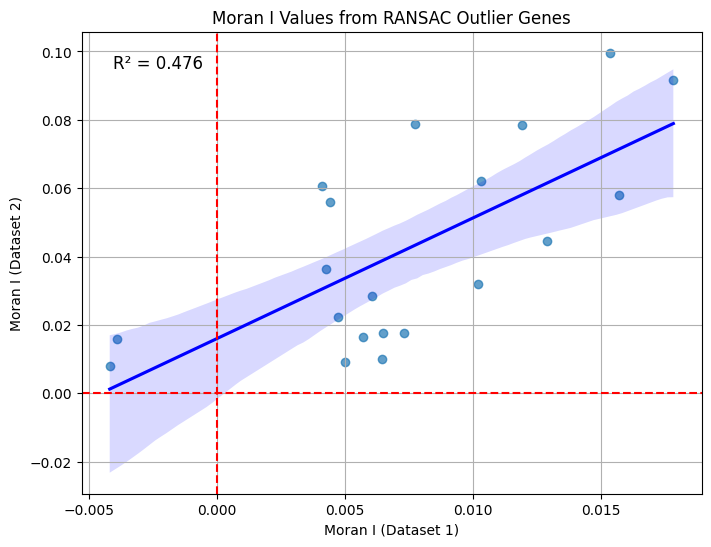

In [47]:
## Plot scatterplot of Moran's score on Outlier genes for both datasets
# Merge the two DataFrames on Gene
merged_df = pd.merge(filtered_res_1[['Gene', 'Moran_I']], filtered_res_2[['Gene', 'Moran_I']], on='Gene', suffixes=('_Dataset1', '_Dataset2'))

# Calculate Pearson correlation coefficient
correlation_coefficient = np.corrcoef(merged_df['Moran_I_Dataset1'], merged_df['Moran_I_Dataset2'])[0, 1]

# Calculate R-squared value
r_squared = correlation_coefficient ** 2
print(f"Correlation Coefficient (R): {correlation_coefficient}")
print(f"R-squared: {r_squared}")

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a scatter plot with a regression line
sns.regplot(data=merged_df, x='Moran_I_Dataset1', y='Moran_I_Dataset2', scatter_kws={'alpha':0.7}, line_kws={'color':'blue'})

# Add titles and labels
plt.title('Moran I Values from RANSAC Outlier Genes')
plt.xlabel('Moran I (Dataset 1)')
plt.ylabel('Moran I (Dataset 2)')

# Add horizontal and vertical lines at y=0 and x=0
plt.axhline(0, color='red', linestyle='--')
plt.axvline(0, color='red', linestyle='--')

# Add R-squared value to the plot
plt.text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

# Show grid
plt.grid()

# Show the plot
plt.show()

Shape of avg_expr_adata1: (120,)
Shape of avg_expr_adata2: (120,)


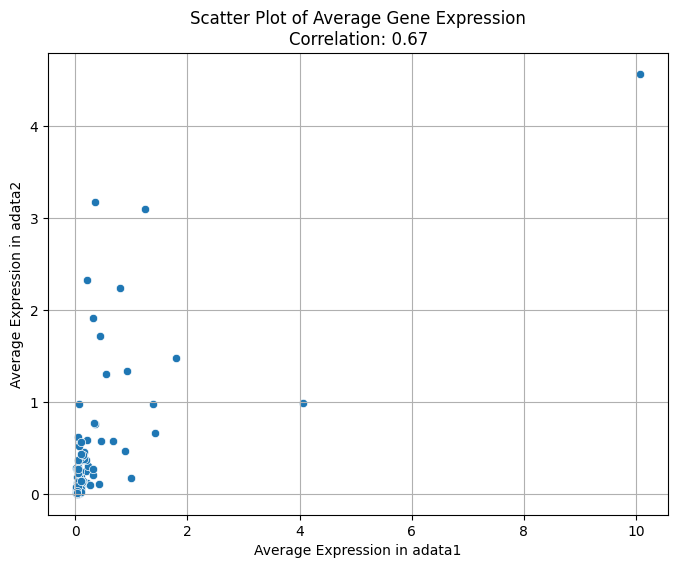

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming adata1 and adata2 are your AnnData objects
# Step 1: Extract common genes
common_genes = adata1.var_names.intersection(adata2.var_names)

# Step 2: Sort common genes
sorted_common_genes = sorted(common_genes)

# Step 3: Reorder AnnData objects based on sorted common genes
adata1_sorted = adata1[:, sorted_common_genes]
adata2_sorted = adata2[:, sorted_common_genes]

# Step 4: Calculate average expression for sorted common genes
avg_expr_adata1 = np.asarray(adata1_sorted.X.mean(axis=0)).flatten()
avg_expr_adata2 = np.asarray(adata2_sorted.X.mean(axis=0)).flatten()

# Check shapes
print("Shape of avg_expr_adata1:", avg_expr_adata1.shape)
print("Shape of avg_expr_adata2:", avg_expr_adata2.shape)

# Step 5: Create a DataFrame with ordered data
data = pd.DataFrame({
    'gene': sorted_common_genes,
    'adata1_avg': avg_expr_adata1,
    'adata2_avg': avg_expr_adata2
})

# Step 6: Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='adata1_avg', y='adata2_avg')

# Step 7: Calculate and display correlation coefficient
correlation = np.corrcoef(data['adata1_avg'], data['adata2_avg'])[0, 1]
plt.title(f'Scatter Plot of Average Gene Expression\nCorrelation: {correlation:.2f}')
plt.xlabel('Average Expression in adata1')
plt.ylabel('Average Expression in adata2')
plt.grid(True)
plt.show()

In [52]:
mask = data['adata1_avg'] >= 1
# Step 2: Filter gene names using the mask
filtered_genes = data.loc[mask, 'gene']

In [56]:
filtered_genes_set = set(filtered_genes)

# Step 2: Count how many filtered genes are in inlier_genes
inlier_count = len(filtered_genes_set.intersection(inlier_genes))

# Step 3: Count how many filtered genes are in outlier_genes
outlier_count = len(filtered_genes_set.intersection(outlier_genes))

In [58]:
inlier_count

0

In [59]:
outlier_count

6

Shape of avg_expr_adata1: (120,)
Shape of avg_expr_adata2: (120,)


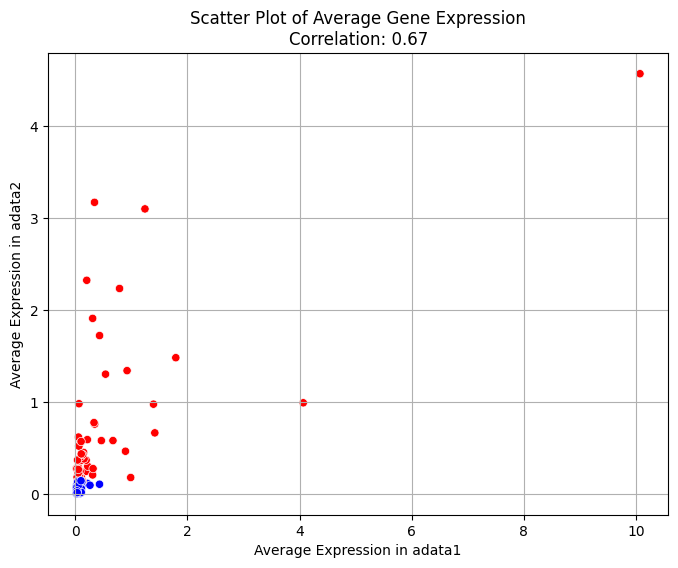

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming adata1 and adata2 are your AnnData objects and outlier_genes is defined
# Step 1: Extract common genes
common_genes = adata1.var_names.intersection(adata2.var_names)

# Step 2: Sort common genes
sorted_common_genes = sorted(common_genes)

# Step 3: Reorder AnnData objects based on sorted common genes
adata1_sorted = adata1[:, sorted_common_genes]
adata2_sorted = adata2[:, sorted_common_genes]

# Step 4: Calculate average expression for sorted common genes
avg_expr_adata1 = np.asarray(adata1_sorted.X.mean(axis=0)).flatten()
avg_expr_adata2 = np.asarray(adata2_sorted.X.mean(axis=0)).flatten()

# Check shapes
print("Shape of avg_expr_adata1:", avg_expr_adata1.shape)
print("Shape of avg_expr_adata2:", avg_expr_adata2.shape)

# Step 5: Create a DataFrame with ordered data
data = pd.DataFrame({
    'gene': sorted_common_genes,
    'adata1_avg': avg_expr_adata1,
    'adata2_avg': avg_expr_adata2
})

# Step 6: Create a new column for color based on outlier genes
data['color'] = np.where(data['gene'].isin(outlier_genes), 'red', 'blue')

# Step 7: Create scatter plot with colors for outliers
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='adata1_avg', y='adata2_avg', hue='color', palette={'red': 'red', 'blue': 'blue'}, legend=False)

# Step 8: Calculate and display correlation coefficient
correlation = np.corrcoef(data['adata1_avg'], data['adata2_avg'])[0, 1]
plt.title(f'Scatter Plot of Average Gene Expression\nCorrelation: {correlation:.2f}')
plt.xlabel('Average Expression in adata1')
plt.ylabel('Average Expression in adata2')
plt.grid(True)
plt.show()

In [ ]:
moran_results_2_fIn
moran_results_1_fIn

moran_results_1_fOut
moran_results_2_fOut

In [61]:
moran_results_1_fIn

,Gene,Moran_I,p_value
0,NCAM1,-0.000881,0.406
1,AQP3,0.015357,0.001
2,AR,0.017848,0.001
3,KDR,-0.001222,0.378
4,KRT23,0.007756,0.003
...,...,...,...
61,TCF7,0.007320,0.005
62,APOC1,0.010320,0.001
63,PRF1,-0.001994,0.238
64,TNFRSF17,0.002515,0.117


In [ ]:
# Convert to DataFrames
moran_results_2_fIn
moran_results_1_fIn

moran_results_1_fOut
moran_results_2_fOut

df_1_fIn = pd.DataFrame(moran_results_1_fIn)
df_2_fIn = pd.DataFrame(moran_results_2_fIn)
df_1_fOut = pd.DataFrame(data_1_fOut)
df_2_fOut = pd.DataFrame(data_2_fOut)

# Add a column to identify the dataset and fIn/fOut
df_1_fIn['Dataset'] = '1 fIn'
df_2_fIn['Dataset'] = '2 fIn'
df_1_fOut['Dataset'] = '1 fOut'
df_2_fOut['Dataset'] = '2 fOut'

# Combine all DataFrames
combined_df = pd.concat([df_1_fIn, df_2_fIn, df_1_fOut, df_2_fOut])

# Set up the plot
plt.figure(figsize=(10, 6))

# Create scatter plot for each dataset
for label in combined_df['Dataset'].unique():
    subset = combined_df[combined_df['Dataset'] == label]
    plt.scatter(subset['Moran_I'], subset['p_value'], label=label)

# Add labels and title
plt.title('Moran\'s I vs p-value')
plt.xlabel('Moran\'s I')
plt.ylabel('p-value')
plt.axhline(y=0.05, color='r', linestyle='--')  # Optional: add a significance line at p=0.05
plt.xlim(-0.02, 0.02)  # Adjust limits as necessary
plt.grid()
plt.legend()
plt.show()